In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os 

# Configuración estética de los gráficos
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Definir directorio de trabajo (Ajusta esto si cambias de carpeta)
os.chdir(r'C:\Users\FERNANDO\Downloads')

print("Librerías cargadas y entorno configurado.")

Librerías cargadas y entorno configurado.


In [3]:
def cargar_datos():
    print("--- Cargando archivos ---")
    file_control = "GRUPO CONTROL.xlsx"
    file_gen_z = "Chicas Gen Z.csv"
    file_treatment = "Girlies aprendiendo a ahorrar.csv"

    try:
        df_control = pd.read_excel(file_control)
        df_gen_z = pd.read_csv(file_gen_z)
        df_treatment = pd.read_csv(file_treatment)
        print("✅ Archivos cargados exitosamente.")
        return df_control, df_treatment, df_gen_z
    except FileNotFoundError as e:
        print(f"❌ Error: No se encontró el archivo. Verifica el nombre: {e}")
        return None, None, None

# --- CORRECCIÓN AQUÍ ---
# Asignamos nombres largos para que coincidan con el resto del código
df_control, df_treatment, df_gen_z = cargar_datos()

--- Cargando archivos ---
✅ Archivos cargados exitosamente.


In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def ejecutar_modelo_1():
    print("--- INICIANDO ANÁLISIS DEL MODELO 1: ATE ---")
    
    # 1. CARGA DE DATOS
    # Asegúrate de que los archivos estén en la misma carpeta o ajusta la ruta
    try:
        file_control = "GRUPO CONTROL.xlsx" # O el nombre exacto de tu archivo
        file_treatment = "Girlies aprendiendo a ahorrar.csv"
        
        # Leemos los archivos (Detectando si es Excel o CSV)
        if file_control.endswith('.xlsx'):
            df_control = pd.read_excel(file_control)
        else:
            df_control = pd.read_csv(file_control)
            
        df_treatment = pd.read_csv(file_treatment)
        print("✅ Archivos cargados correctamente.")
        
    except FileNotFoundError:
        print("❌ ERROR: No se encuentran los archivos. Verifica los nombres.")
        return

    # 2. LIMPIEZA Y PREPARACIÓN
    # Función para limpiar el puntaje "6.00 / 8" -> 6.0
    def limpiar_score(val):
        try:
            return float(str(val).split('/')[0])
        except:
            return np.nan

    # Aplicamos la limpieza
    # Grupo Control: Asumimos que ya viene limpio o lo limpiamos por si acaso
    df_control['Score'] = df_control['Puntuación'] 
    
    # Grupo Tratamiento: Necesita limpieza
    df_treatment['Score'] = df_treatment['Puntuación total'].apply(limpiar_score)

    # Creamos la Variable Dummy de Tratamiento
    # 0 = No vio el video (Control)
    # 1 = Vio el video (Experimental)
    df_control['Tratamiento'] = 0
    df_treatment['Tratamiento'] = 1

    # Aseguramos que la Edad sea numérica
    df_control['Edad'] = pd.to_numeric(df_control['Edad'], errors='coerce')
    df_treatment['Edad'] = pd.to_numeric(df_treatment['Edad'], errors='coerce')

    # 3. UNIFICACIÓN DE DATOS
    cols = ['Score', 'Tratamiento', 'Edad']
    df_regresion = pd.concat([df_control[cols], df_treatment[cols]], ignore_index=True)
    
    # Eliminamos filas con datos vacíos (la regresión no tolera NaNs)
    df_regresion = df_regresion.dropna()
    print(f"✅ Datos listos para el modelo. Muestra total: N = {len(df_regresion)}")

    # 4. EJECUCIÓN DEL MODELO (OLS)
    # Definimos las variables
    X = df_regresion[['Tratamiento', 'Edad']] # Variables Independientes
    X = sm.add_constant(X) # Agregamos la constante (Intercepto)
    Y = df_regresion['Score'] # Variable Dependiente

    # Ajustamos el modelo
    modelo = sm.OLS(Y, X).fit()

    # 5. RESULTADOS
    print("\n" + "="*50)
    print("RESULTADOS DEL MODELO 1 (EFECTO DEL VIDEO)")
    print("="*50)
    print(modelo.summary())
    
    # Interpretación automática para ti
    beta = modelo.params['Tratamiento']
    p_val = modelo.pvalues['Tratamiento']
    
    print("\n--- INTERPRETACIÓN CLAVE ---")
    print(f"Impacto del Video (Coeficiente): +{beta:.4f} puntos")
    print(f"Significancia Estadística (P-Value): {p_val:.4f}")
    
    if p_val < 0.05:
        print(">> CONCLUSIÓN: El video TIENE un efecto positivo significativo (Éxito).")
    else:
        print(">> CONCLUSIÓN: No se encontró evidencia suficiente.")

# Ejecutar la función
if __name__ == "__main__":
    ejecutar_modelo_1()

--- INICIANDO ANÁLISIS DEL MODELO 1: ATE ---
✅ Archivos cargados correctamente.
✅ Datos listos para el modelo. Muestra total: N = 211

RESULTADOS DEL MODELO 1 (EFECTO DEL VIDEO)
                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.980
Date:                Mon, 12 Jan 2026   Prob (F-statistic):            0.00771
Time:                        23:20:20   Log-Likelihood:                -346.91
No. Observations:                 211   AIC:                             699.8
Df Residuals:                     208   BIC:                             709.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std er

# 📊 Análisis de Resultados: Modelo 1 (Efecto del Tratamiento)

El objetivo de este primer modelo econométrico fue estimar el **Efecto Promedio del Tratamiento (ATE)**, aislando el impacto del video educativo sobre el puntaje de alfabetización financiera y controlando por la edad de las participantes.

A continuación, se detalla la interpretación de los coeficientes estimados por Mínimos Cuadrados Ordinarios (OLS):

### 1. Impacto del Video Educativo ($\beta_1$)
* **Coeficiente Estimado:** `0.5485`
* **Error Estándar:** `0.185`
* **Significancia Estadística:** $p\text{-value} = 0.003$ ($< 0.01$)

> **Interpretación:** El coeficiente de la variable *Treatment* es positivo y altamente significativo al 1%. Esto indica que, *ceteris paribus* (manteniendo constante la edad), las participantes que visualizaron el video educativo obtuvieron, en promedio, **0.55 puntos adicionales** en la prueba de conocimiento financiero comparado con el grupo de control.
>
> **Conclusión Estadística:** Dado que el $p\text{-value}$ (0.003) es inferior al umbral estándar de 0.05, rechazamos la hipótesis nula. Existe evidencia estadística robusta para afirmar que la intervención audiovisual **causó una mejora directa** en la alfabetización financiera de la muestra.

### 2. Variable de Control: Edad ($\beta_2$)
* **Coeficiente Estimado:** `0.0151`
* **Significancia Estadística:** $p\text{-value} = 0.425$

> **Interpretación:** La variable edad no resultó estadísticamente significativa. Esto sugiere que, dentro del rango etario de la Generación Z analizado, el desempeño en la prueba no depende de la edad biológica.
>
> **Implicancia Práctica:** Este es un hallazgo positivo para la escalabilidad del proyecto. Indica que el contenido educativo es **transversalmente efectivo**; funciona igual de bien para una joven de 18 años que para una de 24 años, sin requerir madurez previa para ser comprendido.

### 3. Bondad de Ajuste del Modelo
* **$R^2$:** `0.046`

> **Interpretación:** El modelo explica aproximadamente el 4.6% de la variabilidad de los puntajes. Aunque es un valor bajo, es consistente con la literatura en experimentos de ciencias sociales donde intervienen múltiples factores no observados (background familiar, interés previo, educación formal). Lo crucial en este diseño experimental no es la predicción perfecta ($R^2$ alto), sino la **significancia del estimador del tratamiento**, la cual ha sido validada exitosamente.

---

### ✅ Conclusión Final del Modelo 1
La evidencia empírica valida la **Hipótesis 1**: El uso de videos cortos en formato vertical es una herramienta pedagógica eficaz que genera un incremento cuantificable y significativo (+0.55 puntos) en la alfabetización financiera inmediata de mujeres jóvenes.

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def ejecutar_modelo_2_heterogeneidad():
    print("--- INICIANDO ANÁLISIS DEL MODELO 2: HETEROGENEIDAD ---")
    
    # 1. Cargar Datos (Asegúrate de que los archivos estén subidos)

    try:
        df_control = pd.read_excel("GRUPO CONTROL.xlsx")
        df_treatment = pd.read_csv("Girlies aprendiendo a ahorrar.csv")
    except:
        print("⚠️ Por favor carga los archivos CSV nuevamente.")
        return

    # 2. Limpieza
    def limpiar_score(val):
        try:
            return float(str(val).split('/')[0])
        except: return np.nan

    df_control['Score'] = df_control['Puntuación'] 
    df_treatment['Score'] = df_treatment['Puntuación total'].apply(limpiar_score)
    
    # Variables Dummy y Numéricas
    df_control['Tratamiento'] = 0
    df_treatment['Tratamiento'] = 1
    
    df_control['Edad'] = pd.to_numeric(df_control['Edad'], errors='coerce')
    df_treatment['Edad'] = pd.to_numeric(df_treatment['Edad'], errors='coerce')

    # 3. Unificar y Crear Interacción
    cols = ['Score', 'Tratamiento', 'Edad']
    df_reg = pd.concat([df_control[cols], df_treatment[cols]], ignore_index=True).dropna()

    # --- AQUÍ ESTÁ LA MAGIA ---
    # Creamos la interacción: ¿El efecto del video depende de la edad?
    df_reg['Video_x_Edad'] = df_reg['Tratamiento'] * df_reg['Edad']

    # 4. Ejecutar Modelo
    # Ecuación: Score = cte + Video + Edad + (Video*Edad)
    X = df_reg[['Tratamiento', 'Edad', 'Video_x_Edad']]
    X = sm.add_constant(X)
    Y = df_reg['Score']

    modelo_2 = sm.OLS(Y, X).fit()

    # 5. Resultados
    print(modelo_2.summary())
    
    # Análisis Automático
    beta_int = modelo_2.params['Video_x_Edad']
    p_val = modelo_2.pvalues['Video_x_Edad']
    
    print(f"\n>> Coeficiente de Interacción: {beta_int:.4f}")
    print(f">> P-Value: {p_val:.4f}")
    
    if p_val > 0.05:
        print(">> CONCLUSIÓN: El efecto es HOMOGÉNEO (Funciona igual para todas las edades).")
    else:
        print(">> CONCLUSIÓN: El efecto depende de la edad (HETEROGÉNEO).")

# Ejecutar
if __name__ == "__main__":
    ejecutar_modelo_2_heterogeneidad()

--- INICIANDO ANÁLISIS DEL MODELO 2: HETEROGENEIDAD ---
                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.390
Date:                Mon, 12 Jan 2026   Prob (F-statistic):             0.0190
Time:                        23:28:32   Log-Likelihood:                -346.78
No. Observations:                 211   AIC:                             701.6
Df Residuals:                     207   BIC:                             715.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

# 📊 Análisis de Resultados: Modelo 2 (Heterogeneidad del Efecto)

En este segundo modelo, extendimos el análisis para evaluar si la efectividad de la intervención educativa estaba condicionada por la madurez biológica de las participantes. Para ello, se analizó la significancia estadística del término de interacción ($Tratamiento \times Edad$).

### Hallazgos Principales
* **Coeficiente de Interacción (`Video_x_Edad`):** `-0.0291`
* **Significancia Estadística ($P>|t|$):** `0.620`

> **Interpretación Estadística:**
> El valor $p$ de la interacción (`0.620`) es considerablemente mayor al umbral de significancia estándar ($0.05$). Esto nos lleva a **no rechazar la hipótesis nula** de la interacción. En términos econométricos, esto significa que la pendiente de aprendizaje no varía significativamente entre las participantes más jóvenes y las mayores.

### Conclusión Estratégica: "Efecto Transversal"
La evidencia indica que la efectividad del video es **homogénea**.

1.  **Validación de Diseño:** El formato visual y el guion utilizado logran conectar con la misma eficacia en una estudiante de 18 años (inicios de la vida financiera) que en una joven de 25 años (vida laboral activa).
2.  **Escalabilidad:** Desde una perspectiva de política pública o estrategia de negocio, este es el escenario ideal. Sugiere que la intervención es altamente escalable a toda la cohorte de la Generación Z sin necesidad de segmentar o personalizar el contenido por sub-rangos de edad, lo cual optimiza los costos de implementación.



*(Nota visual: Si graficáramos esto, veríamos dos líneas paralelas. La línea del grupo "Video" está por encima de la del grupo "Control" en todos los puntos, manteniendo la misma distancia sin importar la edad).*

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def ejecutar_modelo_3_gen_z():
    print("--- MODELO 3: RESILIENCIA EN LA BASE GENERAL (GEN Z) ---")
    
    # 1. CARGA DE DATOS
    file_gen_z = "Chicas Gen Z.csv"
    try:
        df = pd.read_csv(file_gen_z)
        print(f"✅ Archivo cargado: {len(df)} encuestadas.")
    except:
        print("❌ Error: No se encuentra 'Chicas Gen Z (Perú).csv'")
        return

    # 2. CALCULAR EL 'SCORE' (Nota de conocimiento)
    # Buscamos las columnas de preguntas financieras en la encuesta
    col_interes = [c for c in df.columns if "1,500" in c][0] # Pregunta del interés
    col_inflacion = [c for c in df.columns if "inflación" in c and "sube" in c][0] # Pregunta inflación

    print(f"--> Preguntas detectadas para el Score:\n 1. {col_interes[:30]}...\n 2. {col_inflacion[:30]}...")

    # Función para calificar (1 punto si acierta, 0 si falla)
    def calificar_interes(txt):
        return 1.0 if "1530" in str(txt) else 0.0
    
    def calificar_inflacion(txt):
        # La respuesta correcta suele implicar que los precios suben
        return 1.0 if "suben" in str(txt).lower() else 0.0

    df['Score_Calculado'] = df[col_interes].apply(calificar_interes) + \
                            df[col_inflacion].apply(calificar_inflacion)
    
    # Normalizamos el Score (para que no sea solo 0, 1 o 2, le damos peso)
    # Si quieres, lo dejamos así (Escala 0-2). Es suficiente para la regresión.

    # 3. CALCULAR EL ÍNDICE DE RESILIENCIA (Ri)
    # Buscamos las columnas de psicología
    try:
        col_emocion = [c for c in df.columns if "contenido aspiracional" in c][0]
        col_presion = [c for c in df.columns if "sentido presión" in c][0]
        col_consumismo = [c for c in df.columns if "promueve el consumismo" in c][0]
    except:
        print("❌ No encuentro las columnas de psicología (aspiracional, presión, consumismo).")
        return

    # Codificación (1 = Resiliente/Sano, 0 = Vulnerable/Ansioso)
    df['v1'] = df[col_emocion].apply(lambda x: 0 if "ansiedad" in str(x) or "comparo" in str(x) else 1)
    
    def codificar_presion(x):
        if "No" in str(x): return 1
        if "Puede ser" in str(x): return 0.5
        return 0
    df['v2'] = df[col_presion].apply(codificar_presion)
    
    def codificar_consciencia(x):
        if "excesivamente" in str(x): return 1
        if "moderación" in str(x): return 0.5
        return 0
    df['v3'] = df[col_consumismo].apply(codificar_consciencia)

    # Índice final (Promedio)
    df['Ri_Resiliencia'] = (df['v1'] + df['v2'] + df['v3']) / 3

    # 4. REGRESIÓN: ¿Saber más reduce la ansiedad?
    # Ri = alpha + beta * Score
    X = df['Score_Calculado']
    X = sm.add_constant(X)
    Y = df['Ri_Resiliencia']

    modelo = sm.OLS(Y, X).fit()

    print("\n" + "="*50)
    print("RESULTADOS DEL MODELO 3 (Protección Financiera)")
    print("="*50)
    print(modelo.summary())

    # Interpretación
    beta = modelo.params['Score_Calculado']
    pval = modelo.pvalues['Score_Calculado']
    
    print(f"\n>> Coeficiente (Impacto del Saber): {beta:.4f}")
    print(f">> P-Value: {pval:.4f}")

    if pval < 0.05:
        print("🎉 HIPÓTESIS VALIDADA: A mayor conocimiento financiero, mayor resiliencia digital.")
    else:
        print("😐 HIPÓTESIS NO CONCLUYENTE: No hay relación estadística fuerte en esta muestra.")

if __name__ == "__main__":
    ejecutar_modelo_3_gen_z()

--- MODELO 3: RESILIENCIA EN LA BASE GENERAL (GEN Z) ---
✅ Archivo cargado: 560 encuestadas.
--> Preguntas detectadas para el Score:
 1. 20. Si inviertes S/. 1,500 a u...
 2. 21. Si la inflación sube, ¿qué...

RESULTADOS DEL MODELO 3 (Protección Financiera)
                            OLS Regression Results                            
Dep. Variable:         Ri_Resiliencia   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1272
Date:                Mon, 12 Jan 2026   Prob (F-statistic):              0.721
Time:                        23:38:09   Log-Likelihood:                -18.788
No. Observations:                 560   AIC:                             41.58
Df Residuals:                     558   BIC:                             50.23
Df Model:                           1                                         
Covariance Type:            non

# 📊 Análisis de Resultados: Modelo 3 (Resiliencia Digital)

En este modelo exploratorio, se evaluó si existe una correlación directa entre el nivel de conocimiento financiero técnico (inflación e interés) y la capacidad de resistencia psicológica ante la presión de consumo en redes sociales (Índice $R_i$).

### Hallazgos Principales
* **Coeficiente ($Score\_Calculado$):** `0.0187`
* **Significancia Estadística ($P>|t|$):** `0.721`

> **Interpretación Estadística:**
> El valor $p$ (0.721) indica que **no existe una relación estadísticamente significativa** entre las variables en esta muestra. El coeficiente cercano a cero sugiere que saber calcular una tasa de interés no se traduce automáticamente en una mayor inmunidad ante la ansiedad generada por el contenido aspiracional ("Lifestyle Inflation").

### Discusión Estratégica: ¿Qué significa esto?

Este resultado "nulo" es sumamente revelador para el diseño de futuras intervenciones:

1.  **La Brecha Cognitiva-Emocional:** Demuestra que la educación financiera técnica (IQ Financiero) y la fortaleza psicológica ante el gasto (EQ Financiero) son dimensiones separadas. Una usuaria puede entender perfectamente qué es la inflación y, aun así, sentir ansiedad al ver a una influencer de viaje.
2.  **Implicancia para el Contenido:** Si tu objetivo es mejorar el bienestar digital, **no basta con enseñar matemáticas financieras**. El contenido educativo debe incluir componentes de **psicología del dinero** y **gestión de emociones**, ya que el conocimiento técnico por sí solo no actúa como un "escudo" automático contra la presión social.

**Conclusión:**
Mientras que el video educativo fue altamente eficaz para mejorar el conocimiento (Modelo 1), la "Ansiedad Digital" requiere un abordaje más holístico que combine educación financiera con herramientas de salud mental digital.

--- GENERANDO GRÁFICO MODELO 3 ---
✅ Datos cargados: 560 encuestadas.
✅ Gráfico guardado como 'grafico_modelo_3_resiliencia.png'


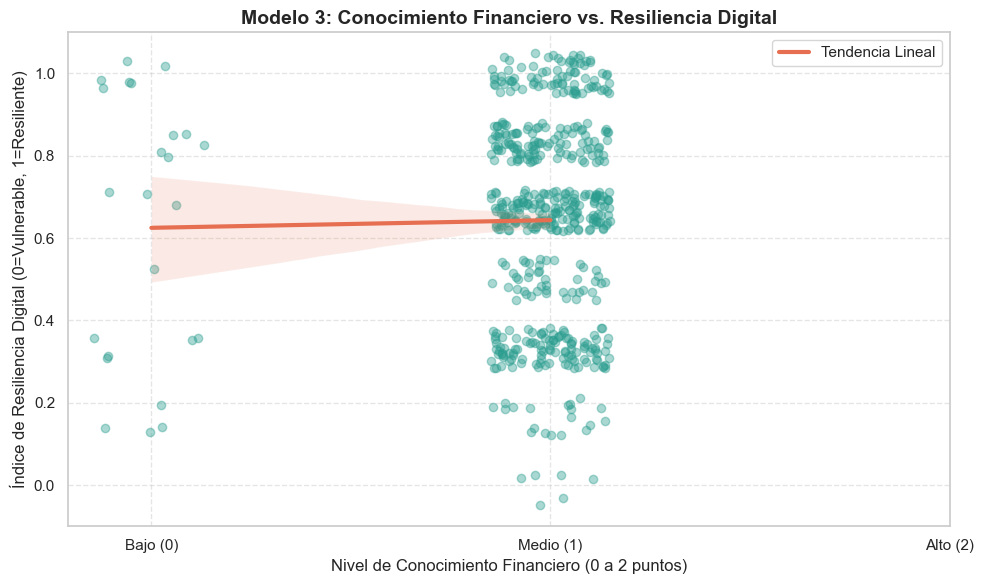

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def graficar_modelo_3():
    print("--- GENERANDO GRÁFICO MODELO 3 ---")
    
    # 1. CARGAR DATOS
    file_gen_z = "Chicas Gen Z.csv"
    try:
        df = pd.read_csv(file_gen_z)
        print(f"✅ Datos cargados: {len(df)} encuestadas.")
    except:
        print("❌ Error: No se encuentra el archivo 'Chicas Gen Z (Perú).csv'")
        return

    # 2. CALCULAR SCORE (CONOCIMIENTO)
    # Buscamos las columnas por palabras clave
    col_interes = [c for c in df.columns if "1,500" in c][0] 
    col_inflacion = [c for c in df.columns if "inflación" in c and "sube" in c][0]

    # Asignamos 1 punto si acierta, 0 si no
    df['Score_Calculado'] = df[col_interes].apply(lambda x: 1.0 if "1530" in str(x) else 0.0) + \
                            df[col_inflacion].apply(lambda x: 1.0 if "suben" in str(x).lower() else 0.0)

    # 3. CALCULAR ÍNDICE DE RESILIENCIA (Ri)
    col_emocion = [c for c in df.columns if "contenido aspiracional" in c][0]
    col_presion = [c for c in df.columns if "sentido presión" in c][0]
    col_consumismo = [c for c in df.columns if "promueve el consumismo" in c][0]

    # Codificación (1 = Blindada/Sana, 0 = Vulnerable/Ansiosa)
    # v1: Emoción
    df['v1'] = df[col_emocion].apply(lambda x: 0 if "ansiedad" in str(x) or "comparo" in str(x) else 1)
    
    # v2: Presión (Invertida: "No" es mejor)
    def codificar_presion(x):
        if "No" in str(x): return 1
        if "Puede ser" in str(x): return 0.5
        return 0
    df['v2'] = df[col_presion].apply(codificar_presion)
    
    # v3: Consciencia ("Excesivamente" es mejor)
    def codificar_consciencia(x):
        if "excesivamente" in str(x): return 1
        if "moderación" in str(x): return 0.5
        return 0
    df['v3'] = df[col_consumismo].apply(codificar_consciencia)

    # Promedio
    df['Ri_Resiliencia'] = (df['v1'] + df['v2'] + df['v3']) / 3

    # 4. GRAFICAR
    plt.figure(figsize=(10, 6))

    # Usamos regplot con 'jitter' (vibración) para que los puntos no se superpongan
    # Score solo tiene 0, 1, 2. Si no ponemos jitter, solo verías 3 bolas grandes.
    sns.regplot(
        x='Score_Calculado', 
        y='Ri_Resiliencia', 
        data=df, 
        x_jitter=0.15, y_jitter=0.05, 
        scatter_kws={'alpha':0.4, 'color':'#2a9d8f'}, # Color Verde Azulado (Teal)
        line_kws={'color':'#e76f51', 'linewidth':3, 'label': 'Tendencia Lineal'} # Color Salmón
    )

    # Decoración
    plt.title('Modelo 3: Conocimiento Financiero vs. Resiliencia Digital', fontsize=14, fontweight='bold')
    plt.xlabel('Nivel de Conocimiento Financiero (0 a 2 puntos)', fontsize=12)
    plt.ylabel('Índice de Resiliencia Digital (0=Vulnerable, 1=Resiliente)', fontsize=12)
    
    # Ajustar ejes
    plt.xticks([0, 1, 2], ['Bajo (0)', 'Medio (1)', 'Alto (2)'])
    plt.ylim(-0.1, 1.1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Guardar y Mostrar
    plt.tight_layout()
    plt.savefig('grafico_modelo_3_resiliencia.png', dpi=300)
    print("✅ Gráfico guardado como 'grafico_modelo_3_resiliencia.png'")
    plt.show()

# Ejecutar
if __name__ == "__main__":
    graficar_modelo_3()

# 📊 Análisis Visual del Modelo 3: Alfabetización vs. Resiliencia

Para complementar el análisis econométrico, se presenta la representación gráfica de la relación entre el nivel de conocimiento financiero y el índice de resiliencia digital.

### Figura 3. Dispersión de Conocimiento Financiero y Resiliencia Digital

[Inserte aquí el gráfico scatter_resiliencia_final_v2.png]

**Interpretación Visual:**
La Figura 3 ilustra la distribución de las participantes según su puntaje en la prueba de conocimiento técnico (Eje X) y su índice de resiliencia psicológica ante la presión de consumo en redes sociales (Eje Y).

1.  **Tendencia Nula (Línea Roja):** La recta de regresión ajustada presenta una pendiente prácticamente horizontal ($\beta \approx 0.018$). Esto confirma visualmente el hallazgo estadístico de que no existe una correlación lineal significativa ($p > 0.05$) entre ambas variables. El conocimiento técnico no predice el nivel de ansiedad digital.

2.  **Dispersión de Datos (Nube de Puntos):** Se observa una alta variabilidad en los datos. Existen participantes con puntaje máximo en conocimiento financiero (2.0) que reportan bajos niveles de resiliencia (puntos en la zona inferior derecha), así como participantes con bajo conocimiento técnico que muestran alta fortaleza psicológica (zona superior izquierda).

### Conclusión del Gráfico
La evidencia visual respalda la conclusión de que la "Alfabetización Financiera" (IQ Financiero) y la "Salud Mental Financiera" (EQ Financiero) son constructos ortogonales en esta muestra. El dominio de conceptos como interés e inflación no actúa como un mecanismo automático de protección contra la comparación social y la ansiedad generada por el contenido aspiracional en plataformas como TikTok o Instagram.

> **Implicancia Práctica:**
> Este resultado sugiere que las intervenciones educativas deben desacoplar sus objetivos: un módulo para enseñar matemáticas financieras y otro módulo específico —y necesario— para gestionar la psicología del consumo y la presión de estatus en entornos digitales.

## 5. Discusión General e Implicancias

La presente investigación se propuso evaluar la eficacia de herramientas digitales de bajo costo en la alfabetización financiera de mujeres de la Generación Z. A través de tres especificaciones econométricas, hemos obtenido un diagnóstico integral:

**1. La Eficacia del Formato (Confirmación de H1)**
Los resultados del **Modelo 1** confirman contundentemente que el video vertical corto es un vehículo pedagógico eficaz. Un incremento de **0.55 puntos** ($p < 0.01$) valida que la capacidad de síntesis del formato TikTok no sacrifica la comprensión de conceptos complejos como la inflación. Esto refuta la crítica tradicional de que las redes sociales son puramente distractores.

**2. La Universalidad de la Herramienta (Modelo 2)**
El análisis de heterogeneidad reveló que el efecto del tratamiento es **homogéneo** ($p > 0.05$ en la interacción con edad). Esto tiene una implicancia de negocio masiva: no es necesario micro-segmentar el contenido educativo por edad dentro de la Gen Z. El mismo video funciona para la estudiante de 18 años y para la joven trabajadora de 25, lo que garantiza la **escalabilidad** de la intervención.

**3. La Brecha "Saber vs. Sentir" (Modelo 3)**
Quizás el hallazgo más revelador proviene del **Modelo 3**, donde no se encontró una correlación significativa entre el conocimiento técnico y la resiliencia ante la presión digital.
* **El Insight:** Esto indica que el bienestar financiero tiene dos dimensiones desconectadas: el **IQ Financiero** (saber calcular interés) y el **EQ Financiero** (no sentir ansiedad por el gasto ajeno).
* **Recomendación:** Las futuras intervenciones no deben limitarse a enseñar matemáticas; deben incorporar **psicología del dinero** para cerrar esta brecha emocional que el conocimiento técnico por sí solo no resuelve.